In [ ]:
!pip -q install torchinfo

In [ ]:
import numpy as np

import torch
from torch import nn
# Get CPU or GPU device
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

from torchinfo import summary

import torch.nn.functional as F

import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm

Using cpu device


# Imports

In [ ]:
!pip -q install kaggle
!mkdir /root/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 108MB/s]


In [ ]:
!unzip -q 'spaceship-titanic.zip' -d /content/spaceship_tmp

In [ ]:
train = pd.read_csv('/content/spaceship_tmp/train.csv')
test = pd.read_csv('/content/spaceship_tmp/test.csv')

train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Custom Dataset

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

In [ ]:
class DataConversion:
    def __init__(self, data: pd.DataFrame, test: bool = False):
        self.test = test

        data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)

        if self.test:
            self.features = data.drop(['Cabin', 'Num', 'Name'], axis=1)
        else:
            self.targets = data['Transported'].replace({True: 1, False: 0})
            self.features = data.drop(['Cabin', 'Num', 'Name', 'Transported'], axis=1)

        self.features['Deck'] = self.features['Deck'].replace('T', 'G')

    @staticmethod
    def get_outliers(num_data: pd.DataFrame) -> pd.DataFrame:
        quantile_1 = num_data.quantile(0.01)
        quantile_3 = num_data.quantile(0.99)

        IQR = quantile_3 - quantile_1
        lower_cond = quantile_1 - 1.5 * IQR
        upper_cond = quantile_3 + 1.5 * IQR

        num_data = num_data[~((num_data < lower_cond) | (num_data > upper_cond))]

        return num_data

    def drop_encode(self):
        features = self.features.copy()

        num_cols = features.keys()[features.dtypes == 'float']
        features[num_cols] = SimpleImputer(strategy='median').fit_transform(features[num_cols])

        features[num_cols] = StandardScaler().fit_transform(features[num_cols])
        features[num_cols] = self.get_outliers(features[num_cols])

        cat_cols = features.keys()[features.dtypes != 'float']
        features[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(features[cat_cols])

        for key in cat_cols: features[key] = LabelEncoder().fit_transform(features[key])

        #features['Shop+Food'] = features['ShoppingMall'] + features['FoodCourt']
        #features.drop(['ShoppingMall', 'FoodCourt'], axis=1, inplace=True)

        if not self.test:
            df = features
            df['Transported'] = self.targets

        return features.dropna() if self.test else df.dropna()

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data: pd.DataFrame, test: bool = False):
        self.test = test
        data_obj = DataConversion(data, test=self.test)

        data = data_obj.drop_encode()
        self.indices = data["PassengerId"]

        self.targets = None if self.test else data[["Transported"]].set_index(self.indices)

        self.data = data.set_index(self.indices).drop(["PassengerId"], axis=1) if self.test else data.set_index(self.indices).drop(["PassengerId", "Transported"], axis=1)
        self.features_cols = self.data.keys()

    def __contains__(self, idx):
        return True if idx in self.indices else False

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        if self.__contains__(idx): return (dict(self.data.loc[idx])) if self.test else (dict(self.data.loc[idx]), dict(self.targets.loc[idx]))

In [ ]:
%%time

train_data = CustomDataset(train.copy(), test=False)

CPU times: user 235 ms, sys: 4.61 ms, total: 240 ms
Wall time: 243 ms


In [ ]:
train_data.features_cols

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side'],
      dtype='object')

In [ ]:
train_data.__getitem__(0)

({'HomePlanet': 1.0,
  'CryoSleep': 0.0,
  'Destination': 2.0,
  'Age': 0.7119453650967104,
  'VIP': 0.0,
  'RoomService': -0.33310465947702855,
  'FoodCourt': -0.2810267305009518,
  'ShoppingMall': -0.2835786325139853,
  'Spa': -0.2706259042558427,
  'VRDeck': -0.26300328786535954,
  'Deck': 1.0,
  'Side': 0.0},
 {'Transported': 0})

In [ ]:
BATCH_SIZE = 128

class CustomSequentialSampler(torch.utils.data.Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self) -> int:
        return len(self.indices)

In [ ]:
def tensor_collate_fn(batch):
    features = dict(
        zip(
            train_data.features_cols, torch.stack([torch.as_tensor(list(item[0].values()), dtype=torch.float) for item in batch], dim=1)
        )
    )
    targets = {"Transported": torch.stack([torch.as_tensor(list(item[1].values()), dtype=torch.int64) for item in batch])}

    return features, targets

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, collate_fn=tensor_collate_fn, sampler=CustomSequentialSampler(train_data.indices)
)

In [ ]:
next(iter(train_dataloader))[0].keys(), torch.as_tensor(next(iter(train_dataloader))[0]["HomePlanet"], dtype=torch.int)

(dict_keys(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side']),
 tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2,
         0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 1, 2,
         2, 1, 0, 2, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 2, 2,
         2, 2, 0, 2, 2, 0, 0, 0], dtype=torch.int32))

# Torch model


In [ ]:
INPUT_SIZE = len(train_data.__getitem__(train_data.indices[0])[0]) # num_features
HIDDEN_SIZE = 64

NUM_CLASSES = 2

INPUT_SIZE

12

In [ ]:
CAT_FEATURES = {col: len(train_data.data[col].unique()) for col in train_data.data.keys() if len(train_data.data[col].unique()) < 20}
NUM_FEATURES = [col for col in train_data.data.keys() if col not in CAT_FEATURES]
NUM_FEATURES, CAT_FEATURES

(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'],
 {'HomePlanet': 3,
  'CryoSleep': 2,
  'Destination': 3,
  'VIP': 2,
  'Deck': 7,
  'Side': 2})

In [ ]:
class SimpleAttention1d(nn.Module):
    def __init__(self, features_dim: int):
        super(SimpleAttention1d, self).__init__()
        self.features_dim = features_dim

        self.linear_block = nn.Sequential(
            nn.Linear(in_features=self.features_dim, out_features=self.features_dim),
            nn.BatchNorm1d(self.features_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        logits = self.linear_block(inputs)
        return torch.multiply(inputs, logits)

In [ ]:
class DenseEmbModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, emb_dim: int = 10, bias: bool = True, num_layers: int = 1,
                 bidirectional: bool = False, dropout_gru: float = 0.0, dropout_lstm: float = 0.0, device: str = "cpu"):
        super(DenseEmbModel, self).__init__()
        self.device = device

        # for cat part
        self.att_layer_cat = SimpleAttention1d(features_dim=input_size).to(self.device)

        self.embeddings = dict()
        for col, num_embs in CAT_FEATURES.items():
            self.embeddings[col] = nn.Embedding(num_embeddings=num_embs, embedding_dim=emb_dim).to(self.device)

        self.bidir = bidirectional
        num_directions = 2 if self.bidir else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=self.bidir,
            dropout=dropout_lstm
        ).to(self.device)

        self.gru = nn.GRU(
            input_size=hidden_size * num_directions,
            hidden_size=hidden_size * num_directions,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=self.bidir,
            dropout=dropout_gru
        ).to(self.device)

        self.out = nn.Linear(in_features=hidden_size * num_directions * num_directions, out_features=output_size, bias=bias).to(device)

        # for num part
        self.att_layer_num = SimpleAttention1d(features_dim=input_size).to(self.device)

        self.linear_enc_dec = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.ReLU(),

            nn.Linear(in_features=input_size*2, out_features=input_size*4),
            nn.BatchNorm1d(input_size*4),
            nn.ReLU(),
            nn.Dropout1d(p=0.2),

            nn.Linear(in_features=input_size*4, out_features=input_size*2),
            nn.BatchNorm1d(input_size*2),
            nn.ReLU(),
            nn.Dropout1d(p=0.2),

            nn.Linear(in_features=input_size*2, out_features=input_size),
            nn.BatchNorm1d(input_size),
            nn.ReLU(),
            nn.Dropout1d(p=0.1),

            nn.Linear(in_features=input_size, out_features=output_size),
            nn.Softmax(dim=1)
        ).to(self.device)


    def forward(self, inputs):
        x_cat = dict(
            zip(
                CAT_FEATURES, self.att_layer_cat(torch.stack([inputs[col].to(self.device) for col in CAT_FEATURES], dim=1)).unbind(dim=1)
            )
        )

        x_cat = torch.stack([self.embeddings[col](torch.as_tensor(inputs[col], dtype=torch.int)) for col in x_cat.keys()], dim=2)


        x_cat, (hidden_state, cell_state) = self.lstm(x_cat)
        states = torch.concatenate((hidden_state, cell_state), dim=2) if self.bidir else hidden_state
        x_cat, _ = self.gru(x_cat, states)
        x_cat = self.out(x_cat[:, -1, :])

        x_num = self.att_layer_num(torch.stack([inputs[col].to(self.device) for col in NUM_FEATURES], dim=1))
        x_num = self.linear_enc_dec(x_num)

        return torch.multiply(x_cat, x_num)

In [ ]:
model_emb_torch = DenseEmbModel(input_size=len(CAT_FEATURES), hidden_size=HIDDEN_SIZE, output_size=NUM_CLASSES, emb_dim=18, num_layers=2, bidirectional=False, device=DEVICE)

model_emb_torch#.forward(next(iter(train_dataloader))).size()

DenseEmbModel(
  (att_layer_cat): SimpleAttention1d(
    (linear_block): Sequential(
      (0): Linear(in_features=6, out_features=6, bias=True)
      (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Softmax(dim=1)
    )
  )
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (gru): GRU(64, 64, num_layers=2, batch_first=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
  (att_layer_num): SimpleAttention1d(
    (linear_block): Sequential(
      (0): Linear(in_features=6, out_features=6, bias=True)
      (1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Softmax(dim=1)
    )
  )
  (linear_enc_dec): Sequential(
    (0): Linear(in_features=6, out_features=12, bias=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=12, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, a

In [ ]:
result = model_emb_torch.forward(next(iter(train_dataloader))[0])
result.size()

torch.Size([128, 2])

# Train

In [ ]:
import time

class TrainModel:
    def __init__(self, data, model, criterion, optimizer, scheduler = None):
        self.data = data
        self.model = model
        self.criterion = criterion

        self.optimizer = optimizer
        self.scheduler = scheduler


    def fit(self, epochs: int = 3, scheduler_step: int = 100, show_step: int = 100):
        n_total_steps = len(self.data)
        dataset_size = len(self.data.dataset)

        for epoch in range(epochs):
            epoch_start_time = time.time()
            print('Epoch %s/%s' % (epoch + 1, epochs))

            n_correct = 0

            for step, (inputs, labels) in enumerate(self.data):
                self.optimizer.zero_grad()

                inputs, labels  = inputs, labels["Transported"].squeeze().to(device)

                output = self.model(inputs)
                n_correct += torch.sum((output.argmax(dim=1) == labels))
                loss = self.criterion(output, labels)

                loss.backward()
                self.optimizer.step()

                if (step+1) % show_step == 0:
                    print(f'Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  Loss: {loss.item():.4f}')

                if (self.scheduler is not None) and (step % scheduler_step == 0): self.scheduler.step()

            print(f'{"-" * 60}\n{" " * 10}Accuracy: {(n_correct.float() / dataset_size):.4f}\n{"-" *60}')

        print('\nDone.')

    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60}
                    criterion: {self.criterion} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [ ]:
opt = torch.optim.NAdam(model_emb_torch.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

train_model = TrainModel(data=train_dataloader, model=model_emb_torch, criterion=nn.CrossEntropyLoss(), optimizer=opt, scheduler=scheduler)
train_model.fit(epochs=5, scheduler_step=len(train_dataloader), show_step=15)

Epoch 1/5
Step [15/68] | Time: 2.11s |  Loss: 0.6160
Step [30/68] | Time: 4.34s |  Loss: 0.6450
Step [45/68] | Time: 5.81s |  Loss: 0.6297
Step [60/68] | Time: 7.42s |  Loss: 0.4991
------------------------------------------------------------
          Accuracy: 0.7072
------------------------------------------------------------
Epoch 2/5
Step [15/68] | Time: 1.49s |  Loss: 0.5296
Step [30/68] | Time: 2.98s |  Loss: 0.5714
Step [45/68] | Time: 4.43s |  Loss: 0.5158
Step [60/68] | Time: 5.91s |  Loss: 0.4838
------------------------------------------------------------
          Accuracy: 0.7519
------------------------------------------------------------
Epoch 3/5
Step [15/68] | Time: 2.28s |  Loss: 0.4864
Step [30/68] | Time: 3.84s |  Loss: 0.5711
Step [45/68] | Time: 5.31s |  Loss: 0.5189
Step [60/68] | Time: 6.77s |  Loss: 0.4318
------------------------------------------------------------
          Accuracy: 0.7656
------------------------------------------------------------
Epoch 4

# Scoring

In [ ]:
def scoring(data, model, test: bool = False):
    with torch.no_grad():
        scores = []
        true_labels = []

        if test:
            for inputs in tqdm(data, desc='Scoring data...', ncols=80):
                output = model(inputs)
                scores.append(output)
        else:
            for (inputs, labels) in tqdm(data, desc='Scoring data...', ncols=80):
                labels = labels["Transported"].squeeze().to(device)

                output = model(inputs)

                scores.append(output)
                true_labels.append(labels)

        scores = torch.concatenate(scores)
        if not test: true_labels = torch.concatenate(true_labels)

        return pd.DataFrame(scores.detach().cpu()) if test else (pd.DataFrame(scores.detach().cpu()), true_labels)

In [ ]:
def accuracy(y_true, probas):
    pred = []
    print('Compute accuracy... ')
    for score in probas.values:
        for key, value in dict(enumerate(score)).items():
            if score.max() == value: pred.append(key)

    n_correct = 0
    for index, value in enumerate(pred):
        if value == y_true[index].cpu().numpy(): n_correct += 1

    return n_correct / len(y_true)

In [ ]:
test_data = CustomDataset(test.copy(), test=True)
test_data.data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side
PassengerId,,,,,,,,,,,,
0,0,1,2,-0.114147,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,6,1
1,0,0,2,-0.684313,0,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,5,1
2,1,1,0,0.170937,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,2,1
3,1,0,2,0.669832,0,-0.357339,4.121518,-0.312173,-0.104002,0.226648,2,1
4,0,0,2,-0.613042,0,-0.340723,-0.283840,0.832122,-0.267841,-0.246712,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,0.384749,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,6,1
4273,0,0,2,0.954916,0,-0.357339,0.277095,-0.281538,-0.258790,-0.130193,5,1
4274,2,1,0,-0.185417,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,3,0


In [ ]:
def custom_test_collate_fn(batch):
    return dict(
        zip(
            test_data.features_cols, torch.stack([torch.as_tensor(list(item.values()), dtype=torch.float) for item in batch], dim=1)
        )
    )

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=BATCH_SIZE, collate_fn=custom_test_collate_fn, sampler=CustomSequentialSampler(test_data.indices)
)

In [ ]:
train_scores, true_labels = scoring(train_dataloader, model_emb_torch)
test_scores = scoring(test_dataloader, model_emb_torch, test=True)

Scoring data...: 100%|██████████████████████████| 34/34 [00:01<00:00, 19.26it/s]


In [ ]:
print('Accuracy on train: %.4f \n' % accuracy(true_labels, train_scores))

Compute accuracy... 
Accuracy on train: 0.7612 



# Calibration

In [ ]:
class ProbaDataset(torch.utils.data.Dataset):
    def __init__(self, proba: pd.DataFrame, targets: torch.Tensor = None, test: bool = False):
        assert type(proba) is pd.DataFrame, 'not pandas dataframe'
        self.test = test

        self.proba = proba
        if not self.test: self.targets = pd.DataFrame(targets)

        self.indices = self.proba.index

    def __contains__(self, idx):
        return True if idx in self.indices else False

    def __len__(self):
        return len(self.proba)

    def __getitem__(self, idx):
        if self.__contains__(idx):
            return  self.proba.loc[idx].values if self.test else (self.proba.loc[idx].values, self.targets.loc[idx].values)

In [ ]:
proba_custom_dataset = ProbaDataset(train_scores, true_labels)
proba_custom_dataset.__getitem__(0)

(array([-1.2672309, -1.8465205], dtype=float32), array([0]))

In [ ]:
proba_test_custom_dataset = ProbaDataset(test_scores, test=True)
proba_test_custom_dataset.__getitem__(0)

array([-0.602495  , -0.00538541], dtype=float32)

In [ ]:
proba_dataloader = torch.utils.data.DataLoader(
    dataset=proba_custom_dataset, batch_size=BATCH_SIZE
)

In [ ]:
proba_test_dataloader = torch.utils.data.DataLoader(
    dataset=proba_test_custom_dataset, batch_size=BATCH_SIZE
)

In [ ]:
next(iter(proba_dataloader))[0].size()

torch.Size([128, 2])

In [ ]:
class LogReg(nn.Module):
    __constants__ = ['in_features']
    weights: torch.Tensor

    def __init__(self, in_features: int, bias: bool = True, device: str = 'cpu', **kwargs) -> None:
        super(LogReg, self).__init__(**kwargs)
        self.device = device

        self.use_bias = bias

        stdv = 1. / torch.math.sqrt(in_features)
        self.weights = nn.Parameter(data=torch.empty(size=(1, in_features), dtype=torch.float), requires_grad=True)
        self.weights.data.uniform_(-stdv, stdv)

        if self.use_bias:
            self.bias = nn.Parameter(data=torch.empty(size=(1, 1), dtype=torch.float), requires_grad=True)
            self.bias.data.uniform_(-stdv, stdv)

        self.sigmoid = nn.Sigmoid()


    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        if self.use_bias: return self.sigmoid(torch.matmul(inputs.to(self.device), torch.transpose(self.weights, dim0=0, dim1=1)) + self.bias.squeeze())
        else: return self.sigmoid(torch.matmul(inputs.to(self.device), torch.transpose(self.weights, dim0=0, dim1=1)))

In [ ]:
model_logreg = LogReg(in_features=train_scores.shape[-1], device=DEVICE)
model_logreg

LogReg(
  (sigmoid): Sigmoid()
)

In [ ]:
import time

class CalibrationModel:
    def __init__(self, data, model, criterion, optimizer, scheduler = None):
        self.data = data
        self.model = model
        self.criterion = criterion

        self.optimizer = optimizer
        self.scheduler = scheduler


    def fit(self, epochs: int = 3, scheduler_step: int = 100, show_step: int = 100):
        n_total_steps = len(self.data)
        dataset_size = len(self.data.dataset)

        for epoch in range(epochs):
            epoch_start_time = time.time()
            print('Epoch %s/%s' % (epoch + 1, epochs))

            n_correct = 0

            for step, (inputs, labels) in enumerate(self.data):
                self.optimizer.zero_grad()

                inputs, labels  = inputs.float(), labels.to(device)

                output = self.model(inputs)
                n_correct += torch.sum((output.round() == labels))
                loss = self.criterion(output, torch.as_tensor(labels, dtype=torch.float))

                loss.backward()
                self.optimizer.step()

                if (step+1) % show_step == 0:
                    print(f'Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  Loss: {loss.item():.4f}')

                if (self.scheduler is not None) and (step % scheduler_step == 0): self.scheduler.step()

            print(f'{"-" * 60}\n{" " * 10}Accuracy: {(n_correct.float() / dataset_size):.4f}\n{"-" *60}')

        print('\nDone.')

    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60}
                    criterion: {self.criterion} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [ ]:
opt = torch.optim.NAdam(model_logreg.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

calibration_model = CalibrationModel(data=proba_dataloader, model=model_logreg, criterion=nn.BCELoss(), optimizer=opt, scheduler=scheduler)

calibration_model.fit(epochs=10, scheduler_step=len(proba_dataloader), show_step=15)

Epoch 1/10
Step [15/68] | Time: 0.32s |  Loss: 0.5691
Step [30/68] | Time: 0.54s |  Loss: 0.5546
Step [45/68] | Time: 0.71s |  Loss: 0.5594
Step [60/68] | Time: 0.89s |  Loss: 0.4521
------------------------------------------------------------
          Accuracy: 0.7573
------------------------------------------------------------
Epoch 2/10
Step [15/68] | Time: 0.18s |  Loss: 0.5567
Step [30/68] | Time: 0.35s |  Loss: 0.5510
Step [45/68] | Time: 0.53s |  Loss: 0.5648
Step [60/68] | Time: 0.72s |  Loss: 0.4468
------------------------------------------------------------
          Accuracy: 0.7615
------------------------------------------------------------
Epoch 3/10
Step [15/68] | Time: 0.19s |  Loss: 0.5558
Step [30/68] | Time: 0.36s |  Loss: 0.5524
Step [45/68] | Time: 0.54s |  Loss: 0.5665
Step [60/68] | Time: 0.72s |  Loss: 0.4462
------------------------------------------------------------
          Accuracy: 0.7625
------------------------------------------------------------
Epoc

# Scoring after calibration

In [ ]:
def scoring_logreg(data, model, test: bool = False):
    with torch.no_grad():
        scores = []
        true_labels = []

        if test:
            for inputs in tqdm(data, desc='Scoring data...', ncols=80):
                output = model(inputs.float())
                scores.append(output)
        else:
            for (inputs, labels) in tqdm(data, desc='Scoring data...', ncols=80):
                labels = labels.squeeze().to(device)

                output = model(inputs.float())

                scores.append(output)
                true_labels.append(labels)

        scores = torch.concatenate(scores)
        if not test: true_labels = torch.concatenate(true_labels)

        return pd.DataFrame(scores.detach().cpu()) if test else (pd.DataFrame(scores.detach().cpu()), true_labels)

In [ ]:
def roc_curve(y_true, probas, class_weight = None):
    assert len(np.unique(y_true)) == 2, 'roc_auc for binary, sorry :('
    assert len(y_true) == len(probas), 'y_true and probas must have the same length'

    sorted_indices = np.argsort(probas)[::-1]

    y_true_sort, probas_sort = y_true[sorted_indices], probas[sorted_indices]

    num_positive = np.sum(y_true == 1)
    num_negative = np.sum(y_true == 0)

    class_weight = class_weight if class_weight is not None else num_negative / num_positive
    weights = np.where(y_true == 1, class_weight, 1.0)[sorted_indices]

    tp, fp = 0, 0
    tpr_values, fpr_values = [], []

    for i, label in enumerate(y_true_sort):
        if label == 1: tp += weights[i]
        else: fp += weights[i]

        tpr = tp / (num_positive * class_weight)
        fpr = fp / num_negative
        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return tpr_values, fpr_values

In [ ]:
train_calib_proba, true_labels = scoring_logreg(proba_dataloader, model_logreg)
test_calib_proba = scoring_logreg(proba_test_dataloader, model_logreg, test=True)

Scoring data...: 100%|█████████████████████████| 34/34 [00:00<00:00, 174.20it/s]


In [ ]:
train_calib_proba.mean(), test_calib_proba.mean()

(0    0.501291
 dtype: float32,
 0    0.503522
 dtype: float32)

In [ ]:
tpr_train, fpr_train = roc_curve(true_labels.numpy(), train_calib_proba.values.ravel())

roc_auc_score: 0.8445

accuracy_train: 0.7601



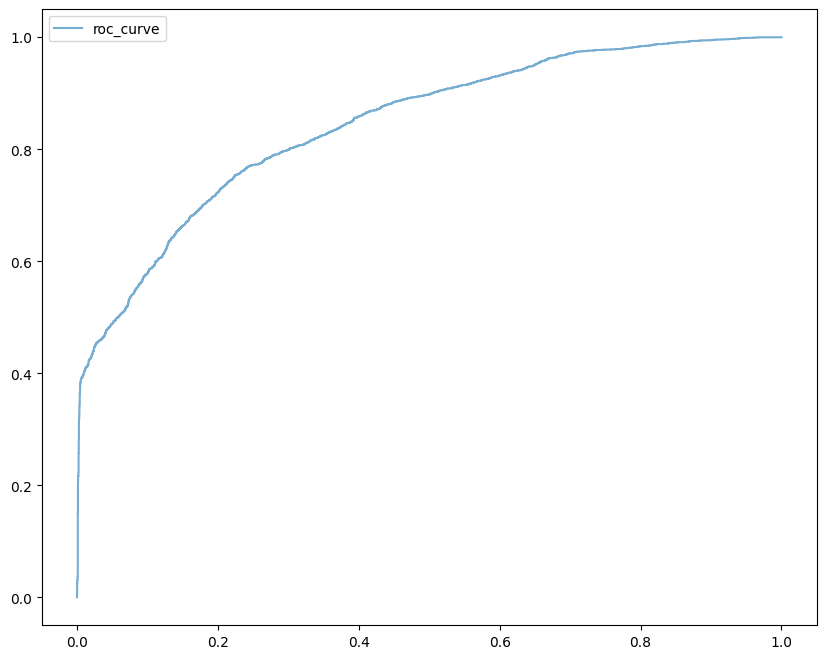

In [ ]:
ax = plt.figure(figsize=(10, 8)).add_subplot()
print("roc_auc_score: %.4f\n" % np.trapz(tpr_train, fpr_train))
print("accuracy_train: %.4f\n" % (torch.sum(torch.from_numpy(train_calib_proba.values.ravel()).round() == true_labels) / len(true_labels)).numpy())

ax.plot(fpr_train, tpr_train, alpha=0.6, label='roc_curve')
ax.legend(loc=2)
plt.show()

# LGBM

In [ ]:
import lightgbm as lgbm

In [ ]:
train_scores_lgbm = lgbm.LGBMClassifier().fit(train_data.data, train_data.targets["Transported"].values).predict_proba(train_data.data)

[LightGBM] [Info] Number of positive: 4361, number of negative: 4288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1374
[LightGBM] [Info] Number of data points in the train set: 8649, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504220 -> initscore=0.016881
[LightGBM] [Info] Start training from score 0.016881


In [ ]:
proba_custom_dataset_lgbm = ProbaDataset(pd.DataFrame(train_scores_lgbm), true_labels)
proba_custom_dataset_lgbm.__getitem__(0)

(array([0.52134286, 0.47865714]), array([0]))

In [ ]:
proba_dataloader_lgbm = torch.utils.data.DataLoader(
    dataset=proba_custom_dataset_lgbm, batch_size=BATCH_SIZE
)

In [ ]:
model_logreg_lgbm = LogReg(in_features=train_scores_lgbm.shape[-1], device=DEVICE)
model_logreg_lgbm

LogReg(
  (sigmoid): Sigmoid()
)

In [ ]:
opt = torch.optim.NAdam(model_logreg_lgbm.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

calibration_model_lgbm = CalibrationModel(data=proba_dataloader_lgbm, model=model_logreg_lgbm, criterion=nn.BCELoss(), optimizer=opt, scheduler=scheduler)

calibration_model_lgbm.fit(epochs=10, scheduler_step=len(proba_dataloader_lgbm), show_step=15)

Epoch 1/10
Step [15/68] | Time: 0.18s |  Loss: 0.5711
Step [30/68] | Time: 0.36s |  Loss: 0.5495
Step [45/68] | Time: 0.54s |  Loss: 0.4984
Step [60/68] | Time: 0.73s |  Loss: 0.4914
------------------------------------------------------------
          Accuracy: 0.8406
------------------------------------------------------------
Epoch 2/10
Step [15/68] | Time: 0.18s |  Loss: 0.4939
Step [30/68] | Time: 0.35s |  Loss: 0.4904
Step [45/68] | Time: 0.59s |  Loss: 0.4476
Step [60/68] | Time: 0.87s |  Loss: 0.4373
------------------------------------------------------------
          Accuracy: 0.8565
------------------------------------------------------------
Epoch 3/10
Step [15/68] | Time: 0.29s |  Loss: 0.4583
Step [30/68] | Time: 0.60s |  Loss: 0.4601
Step [45/68] | Time: 0.89s |  Loss: 0.4192
Step [60/68] | Time: 1.19s |  Loss: 0.4082
------------------------------------------------------------
          Accuracy: 0.8569
------------------------------------------------------------
Epoc

In [ ]:
train_calib_proba_lgbm, true_labels = scoring_logreg(proba_dataloader_lgbm, model_logreg_lgbm)

Scoring data...: 100%|██████████████████████████| 68/68 [00:00<00:00, 83.69it/s]


In [ ]:
train_calib_proba_lgbm.mean()

0    0.508307
dtype: float32

In [ ]:
tpr_train_lgbm, fpr_train_lgbm = roc_curve(true_labels.numpy(), train_calib_proba_lgbm.values.ravel())

roc_auc_score: 0.9428

accuracy_train: 0.8572



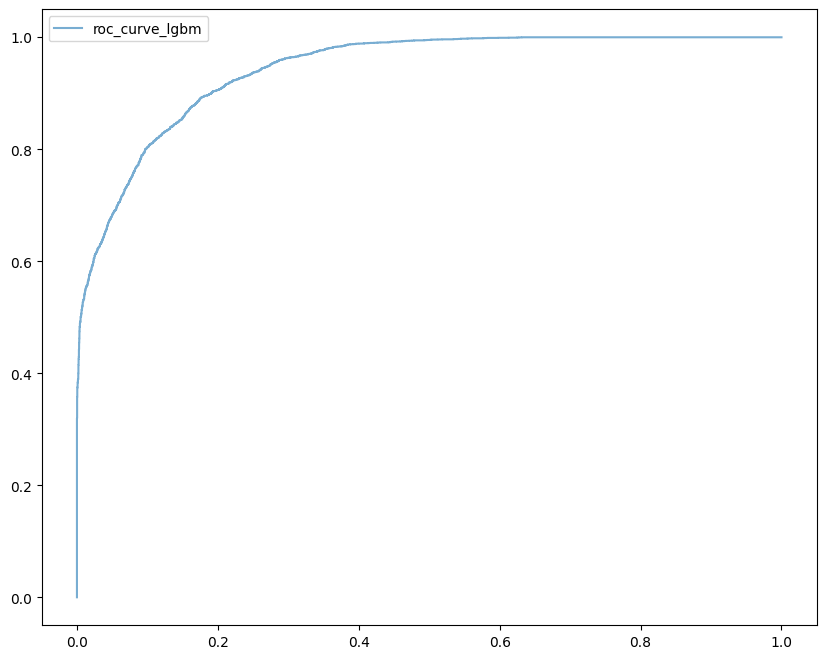

In [ ]:
ax = plt.figure(figsize=(10, 8)).add_subplot()
print("roc_auc_score: %.4f\n" % np.trapz(tpr_train_lgbm, fpr_train_lgbm))
print("accuracy_train: %.4f\n" % (torch.sum(torch.from_numpy(train_calib_proba_lgbm.values.ravel()).round() == true_labels) / len(true_labels)).numpy())

ax.plot(fpr_train_lgbm, tpr_train_lgbm, alpha=0.6, label='roc_curve_lgbm')
ax.legend(loc=2)
plt.show()